In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import root_mean_squared_error, r2_score
from datetime import datetime, timedelta, date


In [6]:
## Préprocessing spécifique pour Prophet

In [7]:
# Import des datasets
df_2023 = pd.read_csv('../../data/raw/2023-comptage-velo-donnees-compteurs.csv', sep=';')
df_2024 = pd.read_csv('../../data/raw/2024-comptage-velo-donnees-compteurs.csv', sep=';')

# Concaténation des années 2023 et 2024
df = pd.concat([df_2023, df_2024], axis=0)

# Gestion des NaNs
cond = (df['Nom du compteur'] == 'Face au 48 quai de la marne NE-SO') & (df['Identifiant du compteur'].isna())
df.loc[cond, 'Identifiant du compteur'] = '100047542-103047542'
df.loc[cond, 'Identifiant du site de comptage'] = 100047542
df.loc[cond, 'Nom du site de comptage'] = 'Face au 48 quai de la marne'
df.loc[cond, "Date d'installation du site de comptage"] = '2018-11-29'
df.loc[cond, 'Coordonnées géographiques'] = '48.89128,2.38606'
cond = (df['Nom du compteur'] == 'Face au 48 quai de la marne SO-NE') & (df['Identifiant du compteur'].isna())
df.loc[cond, 'Identifiant du compteur'] = '100047542-104047542'
df.loc[cond, 'Identifiant du site de comptage'] = 100047542
df.loc[cond, 'Nom du site de comptage'] = 'Face au 48 quai de la marne'
df.loc[cond, "Date d'installation du site de comptage"] = '2018-11-29'
df.loc[cond, 'Coordonnées géographiques'] = '48.89128,2.38606'
cond = (df['Nom du compteur'] == 'Quai des Tuileries NO-SE') & (df['Identifiant du compteur'].isna())
df.loc[cond, 'Identifiant du compteur'] = '100056035-353266462'
df.loc[cond, 'Identifiant du site de comptage'] = 100056035
df.loc[cond, 'Nom du site de comptage'] = 'Quai des Tuileries'
df.loc[cond, "Date d'installation du site de comptage"] = '2021-05-18'
df.loc[cond, 'Coordonnées géographiques'] = '48.8635,2.32239'
cond = (df['Nom du compteur'] == 'Quai des Tuileries SE-NO') & (df['Identifiant du compteur'].isna())
df.loc[cond, 'Identifiant du compteur'] = '100056035-353266460'
df.loc[cond, 'Identifiant du site de comptage'] = 100056035
df.loc[cond, 'Nom du site de comptage'] = 'Quai des Tuileries'
df.loc[cond, "Date d'installation du site de comptage"] = '2021-05-18'
df.loc[cond, 'Coordonnées géographiques'] = '48.8635,2.32239'
cond = (df['Nom du compteur'] == 'Pont des Invalides N-S') & (df['Identifiant du compteur'].isna())
df.loc[cond, 'Identifiant du compteur'] = '100056223-101056223'
df.loc[cond, 'Identifiant du site de comptage'] = 100056223
df.loc[cond, 'Nom du site de comptage'] = 'Pont des Invalides'
df.loc[cond, "Date d'installation du site de comptage"] = '2019-11-07'
df.loc[cond, 'Coordonnées géographiques'] = '48.86281,2.31037'
cond = (df['Nom du compteur'] == '10 avenue de la Grande Armée SE-NO') & (df['Identifiant du compteur'].isna())
df.loc[cond, 'Identifiant du compteur'] = '100044494-353504987'
df.loc[cond, 'Identifiant du site de comptage'] = 100044494
df.loc[cond, 'Nom du site de comptage'] = '10 avenue de la Grande Armée'
df.loc[cond, "Date d'installation du site de comptage"] = '2018-07-27'
df.loc[cond, 'Coordonnées géographiques'] = '48.8748,2.2924'
cond = (df['Nom du compteur'] == '27 quai de la Tournelle NO-SE') & (df['Identifiant du compteur'].isna())
df.loc[cond, 'Identifiant du compteur'] = '100056336-104056336'
df.loc[cond, 'Identifiant du site de comptage'] = 100056336
df.loc[cond, 'Nom du site de comptage'] = '27 quai de la Tournelle'
df.loc[cond, "Date d'installation du site de comptage"] = '2019-11-14'
df.loc[cond, 'Coordonnées géographiques'] = '48.85013,2.35423'
cond = (df['Nom du compteur'] == '27 quai de la Tournelle SE-NO') & (df['Identifiant du compteur'].isna())
df.loc[cond, 'Identifiant du compteur'] = '100056336-103056336'
df.loc[cond, 'Identifiant du site de comptage'] = 100056336
df.loc[cond, 'Nom du site de comptage'] = '27 quai de la Tournelle'
df.loc[cond, "Date d'installation du site de comptage"] = '2019-11-14'
df.loc[cond, 'Coordonnées géographiques'] = '48.85013,2.35423'

# Suppression des variables inutiles pour la modélisation
drop_columns = columns = [
    "Identifiant technique compteur",
    "Nom du site de comptage",
    "ID Photos",
    "test_lien_vers_photos_du_site_de_comptage_",
    "id_photo_1",
    "url_sites",
    "type_dimage",
    "mois_annee_comptage",
    "Lien vers photo du site de comptage",
    "Date d'installation du site de comptage", 
    "Identifiant du compteur", 
    "Identifiant du site de comptage",
    "Coordonnées géographiques"
]

all_df = df.drop(columns = drop_columns)

# Fusion des compteurs doublons identifiés pendant l'exploration
all_df = all_df.replace({
    'Face au 48 quai de la marne Face au 48 quai de la marne Vélos NE-SO': 'Face au 48 quai de la marne NE-SO',
    'Face au 48 quai de la marne Face au 48 quai de la marne Vélos SO-NE': 'Face au 48 quai de la marne SO-NE',
    'Totem 64 Rue de Rivoli Totem 64 Rue de Rivoli Vélos E-O': 'Totem 64 Rue de Rivoli E-O',
    'Totem 64 Rue de Rivoli Totem 64 Rue de Rivoli Vélos O-E': 'Totem 64 Rue de Rivoli O-E',
    'Quai des Tuileries Quai des Tuileries Vélos NO-SE': 'Quai des Tuileries NO-SE',
    'Quai des Tuileries Quai des Tuileries Vélos SE-NO': 'Quai des Tuileries SE-NO',
    'Pont des Invalides (couloir bus)': 'Pont des Invalides',
    '69 Boulevard Ornano (temporaire)': '69 Boulevard Ornano',
    '30 rue Saint Jacques (temporaire)': '30 rue Saint Jacques',
    '27 quai de la Tournelle 27 quai de la Tournelle Vélos NO-SE': '27 quai de la Tournelle NO-SE',
    '27 quai de la Tournelle 27 quai de la Tournelle Vélos SE-NO': '27 quai de la Tournelle SE-NO',
    'Pont des Invalides (couloir bus) N-S': 'Pont des Invalides N-S',
})

# Drop des 2 observations des compteurs dont la direction n'est pas claire
all_df = all_df.drop(index=all_df.loc[all_df['Nom du compteur'] == '10 avenue de la Grande Armée 10 avenue de la Grande Armée [Bike OUT]'].index)
all_df = all_df.drop(index=all_df.loc[all_df['Nom du compteur'] == '10 avenue de la Grande Armée 10 avenue de la Grande Armée [Bike IN]'].index)

# Convertir la colonne en datetime (avec gestion du fuseau horaire)
all_df["Date et heure de comptage"] = pd.to_datetime(all_df["Date et heure de comptage"], utc=True)
all_df["Date et heure de comptage"] = all_df["Date et heure de comptage"].dt.tz_convert("Europe/Paris")
all_df["Date et heure de comptage"] = all_df["Date et heure de comptage"].dt.tz_localize(None)

all_df = all_df.sort_values(by="Date et heure de comptage")
all_df = all_df.drop(all_df[all_df["Date et heure de comptage"].dt.year == 2022].index)

all_df.head()

,Nom du compteur,Comptage horaire,Date et heure de comptage
329540,152 boulevard du Montparnasse E-O,17,2023-01-01 04:00:00
165791,102 boulevard de Magenta SE-NO,110,2023-01-01 04:00:00
572003,Pont de Bercy NE-SO,12,2023-01-01 04:00:00
560445,Face au 40 quai D'Issy SO-NE,2,2023-01-01 04:00:00
173961,Face au 16 avenue de la Porte des Ternes O-E,3,2023-01-01 04:00:00


In [8]:
## Création liste des compteurs

In [9]:
compteurs = list(all_df["Nom du compteur"].unique())

In [10]:
## Creátion des dataframes compatibles avec prophet
compteurs_dfs = {}
for c in all_df["Nom du compteur"].unique():
    compteurs_dfs[c] = all_df.loc[all_df["Nom du compteur"] == c].drop(columns=["Nom du compteur"]).rename(columns={"Date et heure de comptage": "ds", "Comptage horaire": "y"})


In [11]:
## Test de prophet avec un des compteurs

In [12]:
compteur = compteurs[2]
print(compteur)

Pont de Bercy NE-SO


In [13]:
df = compteurs_dfs[compteur].sort_values(by="ds")

In [14]:
## Séparation données entrainement et de test

In [15]:
df_train = df.loc[df.ds.dt.year < 2025]
df_test = df.loc[df.ds.dt.year == 2025]

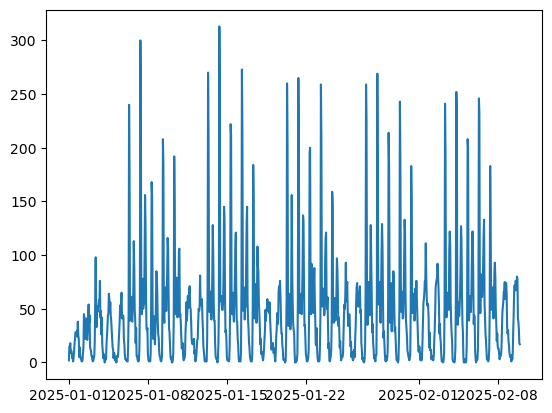

In [16]:
plt.plot(df_test.ds, df_test.y)

In [ ]:
## Génération du dataframe des vacances scolaires zone C

In [17]:
def list_dates(begin, end):
    start_date = date.fromisoformat(begin)
    end_date = date.fromisoformat(end)
    
    current_date = start_date
    liste = []
    while current_date <= end_date:
        liste.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return liste


In [18]:
vacances = [
    ("2022-12-17", "2023-01-03"),
    ("2023-02-18", "2023-03-06"),
    ("2023-04-22", "2023-05-09"),
    ("2023-07-08", "2023-09-03"),
    ("2023-10-21", "2023-11-06"),
    ("2023-12-24", "2024-01-08"),
    ("2024-02-10", "2024-02-26"),
    ("2024-04-06", "2024-04-22"),
    ("2024-05-08", "2024-05-13"),
    ("2024-07-06", "2024-09-02"),
    ("2024-10-19", "2024-11-04"),
    ("2024-12-21", "2025-01-05"),
    ("2025-02-15", "2025-03-02"),
    ("2025-04-12", "2025-04-27"),
    ("2025-07-05", "2025-08-31"),
    ("2025-10-18", "2025-11-02"),
    ("2025-12-20", "2026-01-04"),
]
dates = []
for b, e in vacances:
    dates += list_dates(b, e)

vacances_df = pd.DataFrame({
  'holiday': 'vacances',
  'ds': pd.to_datetime(dates),
})


In [19]:
prophet = Prophet(
    seasonality_mode='additive',
    growth='flat',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    holidays=vacances_df,
)


In [20]:
prophet.add_country_holidays(country_name="FR")

In [21]:
prophet.fit(df_train)

16:01:59 - cmdstanpy - INFO - Chain [1] start processing
16:01:59 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = prophet.make_future_dataframe(periods=14*24, freq='h')
future.tail()

,ds
17865,2025-01-14 19:00:00
17866,2025-01-14 20:00:00
17867,2025-01-14 21:00:00
17868,2025-01-14 22:00:00
17869,2025-01-14 23:00:00


In [23]:
forecast = prophet.predict(future)

In [24]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Armistice Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
17865,2025-01-14 19:00:00,59.143656,45.256758,145.430631,59.143656,59.143656,0.0,0.0,0.0,0.0,...,9.064600,9.064600,9.064600,-15.746950,-15.746950,-15.746950,0.0,0.0,0.0,94.445805
17866,2025-01-14 20:00:00,59.143656,27.754865,129.150815,59.143656,59.143656,0.0,0.0,0.0,0.0,...,8.965271,8.965271,8.965271,-15.721594,-15.721594,-15.721594,0.0,0.0,0.0,80.218644
17867,2025-01-14 21:00:00,59.143656,0.138785,100.992516,59.143656,59.143656,0.0,0.0,0.0,0.0,...,8.883765,8.883765,8.883765,-15.696182,-15.696182,-15.696182,0.0,0.0,0.0,51.583640
17868,2025-01-14 22:00:00,59.143656,-30.100637,75.355532,59.143656,59.143656,0.0,0.0,0.0,0.0,...,8.820777,8.820777,8.820777,-15.670716,-15.670716,-15.670716,0.0,0.0,0.0,23.135358
17869,2025-01-14 23:00:00,59.143656,-40.068707,64.495097,59.143656,59.143656,0.0,0.0,0.0,0.0,...,8.776682,8.776682,8.776682,-15.645196,-15.645196,-15.645196,0.0,0.0,0.0,10.124169


/opt/anaconda3/envs/prophet_venv/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/prophet_venv/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


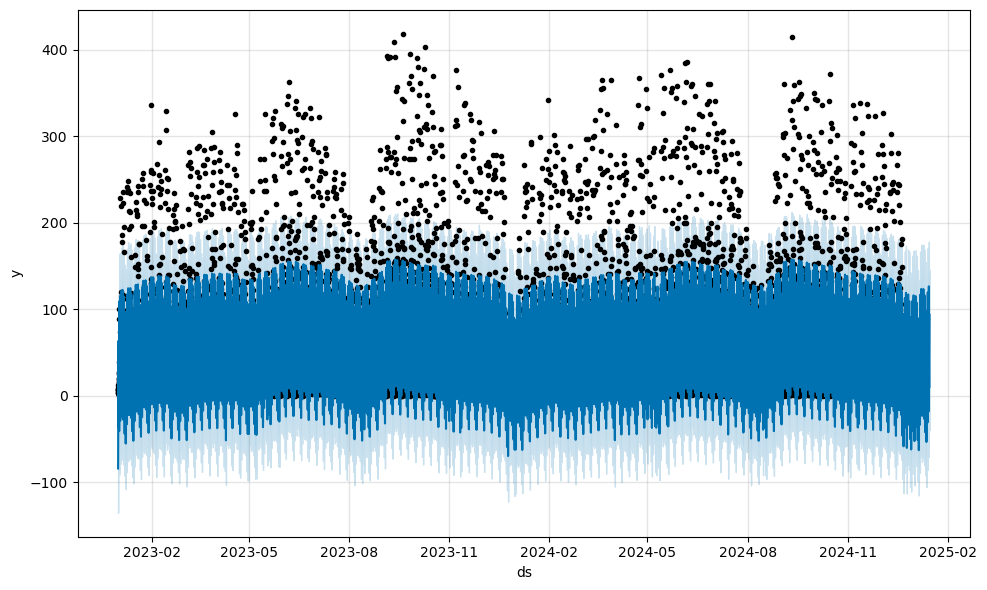

In [25]:
prophet.plot(forecast);

/opt/anaconda3/envs/prophet_venv/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/prophet_venv/lib/python3.9/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/opt/anaconda3/envs/prophet_venv/lib/python3.9/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects

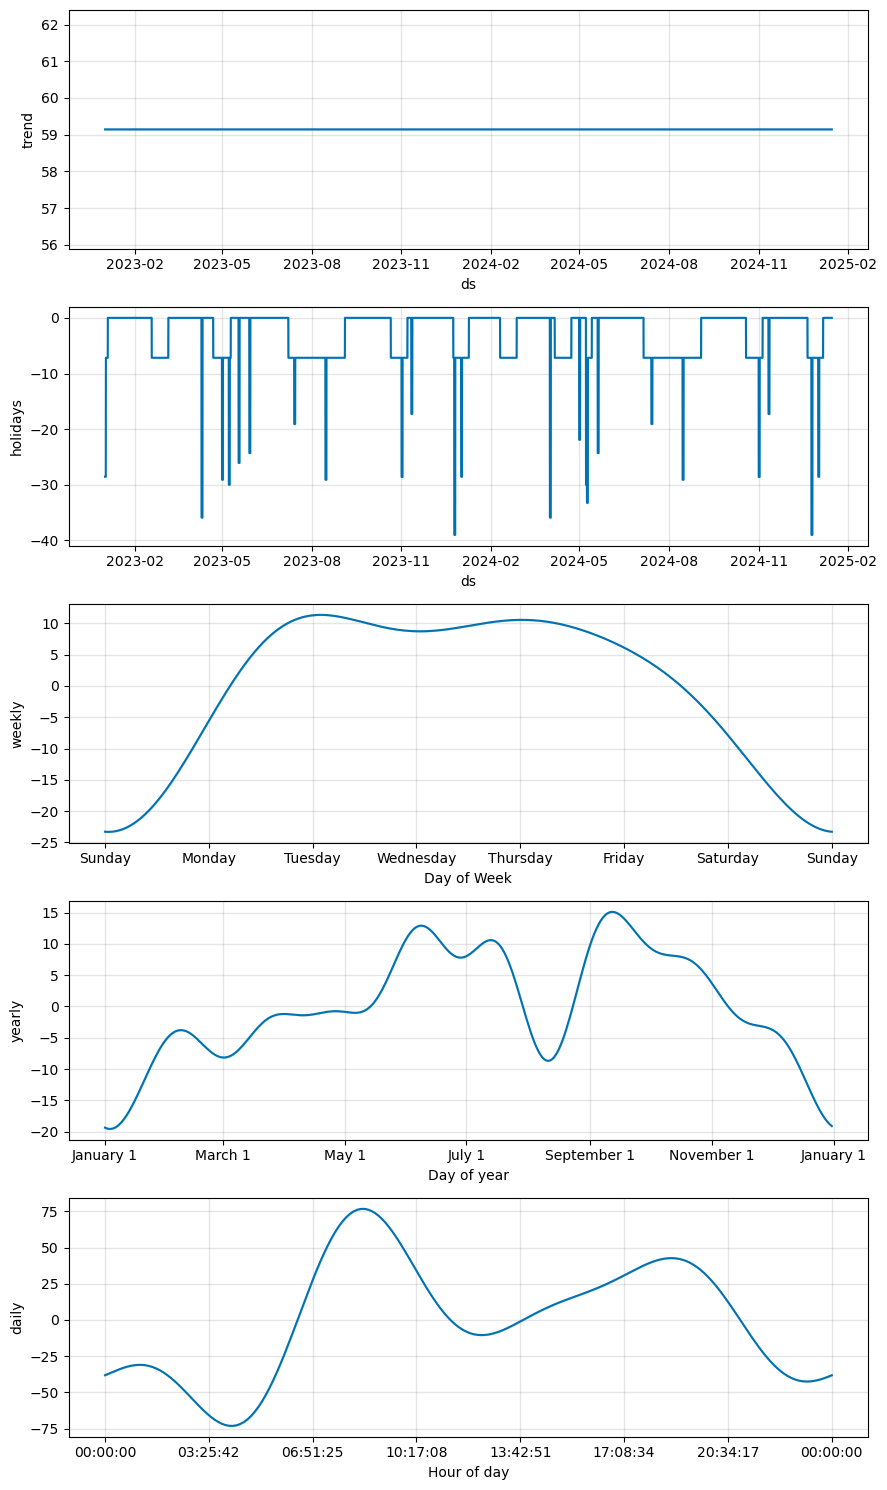

In [26]:
prophet.plot_components(forecast);

In [27]:
rmse = root_mean_squared_error(df_test['y'].iloc[:336], forecast['yhat'].loc[forecast.ds.dt.year == 2025])
print(f'Erreur quadratique moyenne (RMSE) : {rmse}')

Erreur quadratique moyenne (RMSE) : 36.60882551711745


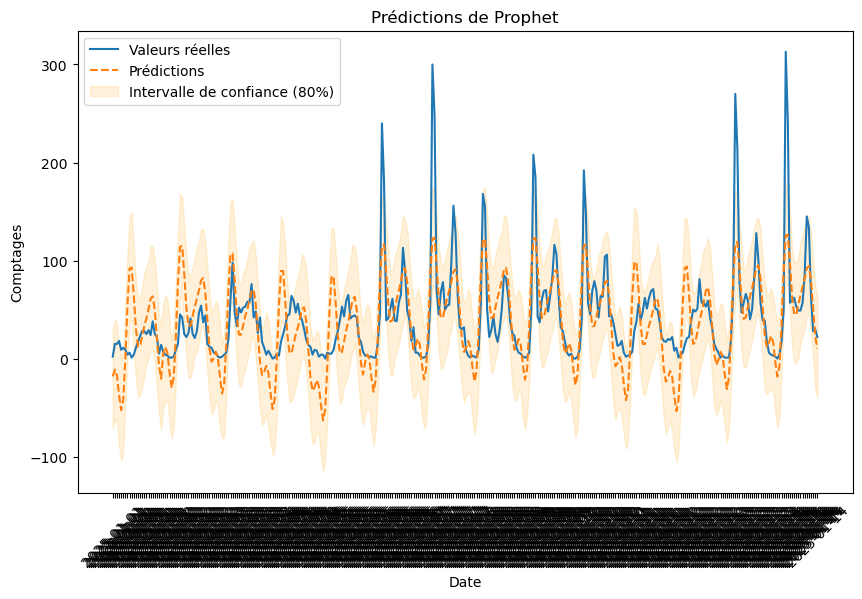

In [28]:
plt.figure(figsize=(10, 6))
x = df_test['ds'].iloc[:336]
df_y = df.loc[df.ds.dt.year == 2025].iloc[:336].y
pred_y = forecast['yhat'].loc[forecast.ds.dt.year == 2025]
plt.plot(x, df_y, label='Valeurs réelles')
plt.plot(x, pred_y, label='Prédictions', linestyle='--')
plt.fill_between(x, forecast['yhat_lower'].loc[forecast.ds.dt.year == 2025], forecast['yhat_upper'].loc[forecast.ds.dt.year == 2025],
color='orange', alpha=0.15, label='Intervalle de confiance (80%)')
plt.title('Prédictions de Prophet')
plt.xlabel('Date')
plt.xticks(x, rotation=45)
plt.ylabel('Comptages')
plt.legend();

In [29]:
## Fonction pour entrainer prophet sur un compteur et renvoyer score r2 et RMSE

In [30]:
def prophet_compteur(compteur):
    print(compteur)
    df = compteurs_dfs[compteur].sort_values(by="ds")
    df_train = df.loc[df.ds.dt.year < 2025]
    df_test = df.loc[df.ds.dt.year == 2025]
    prophet = Prophet(
        seasonality_mode='additive',
        growth='flat',
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        holidays=vacances_df,
    )
    prophet.add_country_holidays(country_name="FR")
    prophet.fit(df_train)
    forecast = prophet.predict(df_test)
    r2_test = r2_score(df_test['y'], forecast['yhat'])
    rmse = root_mean_squared_error(df_test['y'], forecast['yhat'])
    print(f'R2 score test : {r2_test}')
    print(f'Erreur quadratique moyenne (RMSE) : {rmse}')
    return r2_test, rmse

In [ ]:
## Filtrage des compteurs décommissionnés en 2025

In [31]:
for c in compteurs_dfs:
    if c in compteurs and len(compteurs_dfs[c].loc[compteurs_dfs[c].ds.dt.year == 2025]) == 0:
        compteurs.remove(c)

In [ ]:
## Entrainement de prophet sur tous les compteurs

In [32]:
rmsel = []
r2l = []
for c in compteurs:
    r2, rmse = prophet_compteur(c)
    r2l.append(r2)
    rmsel.append(rmse)


152 boulevard du Montparnasse E-O


16:03:09 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6413688018248411
Erreur quadratique moyenne (RMSE) : 23.841677630870382
102 boulevard de Magenta SE-NO


16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:11 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6760715336150128
Erreur quadratique moyenne (RMSE) : 75.67514025484164
Pont de Bercy NE-SO


16:03:11 - cmdstanpy - INFO - Chain [1] start processing
16:03:12 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5031987832097757
Erreur quadratique moyenne (RMSE) : 35.403571872004036
Face au 40 quai D'Issy SO-NE


16:03:12 - cmdstanpy - INFO - Chain [1] start processing
16:03:13 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4710474622224238
Erreur quadratique moyenne (RMSE) : 17.37101215588296
Face au 16 avenue de la  Porte des Ternes O-E


16:03:13 - cmdstanpy - INFO - Chain [1] start processing
16:03:14 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.44013875761683396
Erreur quadratique moyenne (RMSE) : 20.513737664069936
Pont du Garigliano SE-NO


16:03:14 - cmdstanpy - INFO - Chain [1] start processing
16:03:15 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4868024742075825
Erreur quadratique moyenne (RMSE) : 36.6353433229893
35 boulevard de Ménilmontant NO-SE


16:03:15 - cmdstanpy - INFO - Chain [1] start processing
16:03:16 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6122965931818874
Erreur quadratique moyenne (RMSE) : 74.19569555446718
38 rue Turbigo NE-SO


16:03:16 - cmdstanpy - INFO - Chain [1] start processing
16:03:17 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4733902594959031
Erreur quadratique moyenne (RMSE) : 70.82457605162645
38 rue Turbigo SO-NE


16:03:17 - cmdstanpy - INFO - Chain [1] start processing
16:03:17 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6115018771162404
Erreur quadratique moyenne (RMSE) : 71.58769294201971
Quai d'Orsay E-O


16:03:18 - cmdstanpy - INFO - Chain [1] start processing
16:03:18 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.06544202350972095
Erreur quadratique moyenne (RMSE) : 94.08510290005057
Pont National NE-SO


16:03:19 - cmdstanpy - INFO - Chain [1] start processing
16:03:19 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4759155528476725
Erreur quadratique moyenne (RMSE) : 56.9978215629054
Quai d'Orsay O-E


16:03:20 - cmdstanpy - INFO - Chain [1] start processing
16:03:20 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.19388754001286646
Erreur quadratique moyenne (RMSE) : 116.43832666697232
Voie Georges Pompidou NE-SO


16:03:21 - cmdstanpy - INFO - Chain [1] start processing
16:03:21 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5247663790820825
Erreur quadratique moyenne (RMSE) : 28.414069052497272
Pont de Bercy SO-NE


16:03:22 - cmdstanpy - INFO - Chain [1] start processing
16:03:22 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6252069334940578
Erreur quadratique moyenne (RMSE) : 26.26364551994678
Face au 25 quai de l'Oise SO-NE


16:03:23 - cmdstanpy - INFO - Chain [1] start processing
16:03:23 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.42859818581356257
Erreur quadratique moyenne (RMSE) : 32.7686574383644
152 boulevard du Montparnasse O-E


16:03:24 - cmdstanpy - INFO - Chain [1] start processing
16:03:24 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6270031798952578
Erreur quadratique moyenne (RMSE) : 25.671576586257128
27 quai de la Tournelle NO-SE


16:03:25 - cmdstanpy - INFO - Chain [1] start processing
16:03:25 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5973490328354465
Erreur quadratique moyenne (RMSE) : 42.33422070178762
Face au 25 quai de l'Oise NE-SO


16:03:26 - cmdstanpy - INFO - Chain [1] start processing
16:03:26 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6933683270887516
Erreur quadratique moyenne (RMSE) : 28.57376819425638
27 quai de la Tournelle SE-NO


16:03:27 - cmdstanpy - INFO - Chain [1] start processing
16:03:27 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5586313681760111
Erreur quadratique moyenne (RMSE) : 82.65768201208736
Totem 85 quai d'Austerlitz NO-SE


16:03:28 - cmdstanpy - INFO - Chain [1] start processing
16:03:28 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6002536087011952
Erreur quadratique moyenne (RMSE) : 42.51363868939726
6 rue Julia Bartet SO-NE


16:03:29 - cmdstanpy - INFO - Chain [1] start processing
16:03:29 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.48167629590081984
Erreur quadratique moyenne (RMSE) : 48.98906976702577
18 quai de l'Hôtel de Ville NO-SE


16:03:30 - cmdstanpy - INFO - Chain [1] start processing
16:03:30 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5887377048911946
Erreur quadratique moyenne (RMSE) : 13.56710076271724
Totem 85 quai d'Austerlitz SE-NO


16:03:31 - cmdstanpy - INFO - Chain [1] start processing
16:03:31 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4881444755466573
Erreur quadratique moyenne (RMSE) : 62.94667643502717
6 rue Julia Bartet NE-SO


16:03:32 - cmdstanpy - INFO - Chain [1] start processing
16:03:32 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6197868539895858
Erreur quadratique moyenne (RMSE) : 36.80410393743665
21 boulevard Auguste Blanqui SO-NE


16:03:33 - cmdstanpy - INFO - Chain [1] start processing
16:03:33 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5440543957683845
Erreur quadratique moyenne (RMSE) : 23.986269212221295
Totem Cours la Reine E-O


16:03:34 - cmdstanpy - INFO - Chain [1] start processing
16:03:34 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : -0.06586444856224838
Erreur quadratique moyenne (RMSE) : 29.947752214524915
Totem Cours la Reine O-E


16:03:35 - cmdstanpy - INFO - Chain [1] start processing
16:03:35 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4823014499474084
Erreur quadratique moyenne (RMSE) : 57.06402315142515
39 quai François Mauriac SE-NO


16:03:36 - cmdstanpy - INFO - Chain [1] start processing
16:03:36 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.578274717036574
Erreur quadratique moyenne (RMSE) : 38.68381692537932
Face au 70 quai de Bercy S-N


16:03:37 - cmdstanpy - INFO - Chain [1] start processing
16:03:37 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4937345141193764
Erreur quadratique moyenne (RMSE) : 39.65127187567498
18 quai de l'Hôtel de Ville SE-NO


16:03:38 - cmdstanpy - INFO - Chain [1] start processing
16:03:38 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4865589357388108
Erreur quadratique moyenne (RMSE) : 18.57034651022294
Face au 40 quai D'Issy NE-SO


16:03:39 - cmdstanpy - INFO - Chain [1] start processing
16:03:39 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.507231842200839
Erreur quadratique moyenne (RMSE) : 21.612417731275926
36 quai de Grenelle NE-SO


16:03:40 - cmdstanpy - INFO - Chain [1] start processing
16:03:40 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5459571989476518
Erreur quadratique moyenne (RMSE) : 46.990697483506786
10 boulevard Auguste Blanqui NE-SO


16:03:41 - cmdstanpy - INFO - Chain [1] start processing
16:03:41 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5876962479683311
Erreur quadratique moyenne (RMSE) : 22.389252139623807
72 boulevard Voltaire NO-SE


16:03:42 - cmdstanpy - INFO - Chain [1] start processing
16:03:42 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6926639338562757
Erreur quadratique moyenne (RMSE) : 68.88188248121351
147 avenue d'Italie S-N


16:03:43 - cmdstanpy - INFO - Chain [1] start processing
16:03:43 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6015465254584471
Erreur quadratique moyenne (RMSE) : 23.015728391529866
33 avenue des Champs Elysées NO-SE


16:03:44 - cmdstanpy - INFO - Chain [1] start processing
16:03:44 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5444174934663619
Erreur quadratique moyenne (RMSE) : 58.6791102331639
132 rue Lecourbe NE-SO


16:03:45 - cmdstanpy - INFO - Chain [1] start processing
16:03:45 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.606620451288978
Erreur quadratique moyenne (RMSE) : 27.39516618938232
129 rue Lecourbe SO-NE


16:03:46 - cmdstanpy - INFO - Chain [1] start processing
16:03:46 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5811913661090623
Erreur quadratique moyenne (RMSE) : 28.609518369301888
180 avenue d'Italie N-S


16:03:47 - cmdstanpy - INFO - Chain [1] start processing
16:03:47 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6022073713267638
Erreur quadratique moyenne (RMSE) : 23.169414165997292
Pont de la Concorde N-S


16:03:48 - cmdstanpy - INFO - Chain [1] start processing
16:03:48 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.581570170723909
Erreur quadratique moyenne (RMSE) : 64.09571863591641
89 boulevard de Magenta NO-SE


16:03:49 - cmdstanpy - INFO - Chain [1] start processing
16:03:49 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6034214758785437
Erreur quadratique moyenne (RMSE) : 90.63970089745871
7 avenue de la Grande Armée NO-SE


16:03:50 - cmdstanpy - INFO - Chain [1] start processing
16:03:50 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5462492882176988
Erreur quadratique moyenne (RMSE) : 23.572204706267446
Pont des Invalides S-N


16:03:51 - cmdstanpy - INFO - Chain [1] start processing
16:03:51 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4886058672062278
Erreur quadratique moyenne (RMSE) : 43.12341301092768
44 avenue des Champs Elysées SE-NO


16:03:52 - cmdstanpy - INFO - Chain [1] start processing
16:03:52 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.507567921285309
Erreur quadratique moyenne (RMSE) : 50.639980475222224
Pont de la Concorde S-N


16:03:53 - cmdstanpy - INFO - Chain [1] start processing
16:03:53 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6074706385248945
Erreur quadratique moyenne (RMSE) : 61.04960696760759
Pont des Invalides N-S


16:03:54 - cmdstanpy - INFO - Chain [1] start processing
16:03:54 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.572087344778242
Erreur quadratique moyenne (RMSE) : 27.09909475085129
72 avenue de Flandre SO-NE


16:03:55 - cmdstanpy - INFO - Chain [1] start processing
16:03:55 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.540134011186056
Erreur quadratique moyenne (RMSE) : 39.8384833748339
36 quai de Grenelle SO-NE


16:03:56 - cmdstanpy - INFO - Chain [1] start processing
16:03:56 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5038013103865486
Erreur quadratique moyenne (RMSE) : 37.96704434559762
10 avenue de la Grande Armée SE-NO


16:03:57 - cmdstanpy - INFO - Chain [1] start processing
16:03:57 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.0
Erreur quadratique moyenne (RMSE) : 23.157279833037194
Face au 8 avenue de la porte de Charenton NO-SE


16:03:57 - cmdstanpy - INFO - Chain [1] start processing
16:03:58 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : -18.933563242349223
Erreur quadratique moyenne (RMSE) : 17.21612422639083
16 avenue de la Porte des Ternes E-O


16:03:58 - cmdstanpy - INFO - Chain [1] start processing
16:03:59 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4342408942013557
Erreur quadratique moyenne (RMSE) : 21.215999668883786
Face au 8 avenue de la porte de Charenton SE-NO


16:03:59 - cmdstanpy - INFO - Chain [1] start processing
16:04:00 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : -635.1379357340262
Erreur quadratique moyenne (RMSE) : 34.26650788035365
Face au 4 avenue de la porte de Bagnolet E-O


16:04:00 - cmdstanpy - INFO - Chain [1] start processing
16:04:01 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5741388700204777
Erreur quadratique moyenne (RMSE) : 30.74440700884945
Totem 64 Rue de Rivoli O-E


16:04:01 - cmdstanpy - INFO - Chain [1] start processing
16:04:02 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6827019580516481
Erreur quadratique moyenne (RMSE) : 92.19723741259332
Totem 64 Rue de Rivoli E-O


16:04:02 - cmdstanpy - INFO - Chain [1] start processing
16:04:03 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5581590886023667
Erreur quadratique moyenne (RMSE) : 98.21867007244447
67 boulevard Voltaire SE-NO


16:04:03 - cmdstanpy - INFO - Chain [1] start processing
16:04:04 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5330792805476273
Erreur quadratique moyenne (RMSE) : 84.8175918306032
Face au 4 avenue de la porte de Bagnolet O-E


16:04:04 - cmdstanpy - INFO - Chain [1] start processing
16:04:05 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.667825358502661
Erreur quadratique moyenne (RMSE) : 16.478605583918615
Pont Charles De Gaulle NE-SO


16:04:05 - cmdstanpy - INFO - Chain [1] start processing
16:04:06 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4892950103497129
Erreur quadratique moyenne (RMSE) : 35.47240246166298
Pont Charles De Gaulle SO-NE


16:04:06 - cmdstanpy - INFO - Chain [1] start processing
16:04:07 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5693971057747353
Erreur quadratique moyenne (RMSE) : 31.74734113513284
243 boulevard Saint Germain NO-SE


16:04:07 - cmdstanpy - INFO - Chain [1] start processing
16:04:08 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6137623574824624
Erreur quadratique moyenne (RMSE) : 35.225339250410194
Pont du Garigliano NO-SE


16:04:08 - cmdstanpy - INFO - Chain [1] start processing
16:04:09 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5733317623387277
Erreur quadratique moyenne (RMSE) : 37.64372281781875
Voie Georges Pompidou SO-NE


16:04:10 - cmdstanpy - INFO - Chain [1] start processing
16:04:10 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.42577517489982153
Erreur quadratique moyenne (RMSE) : 66.4304231752889
Totem 73 boulevard de Sébastopol N-S


16:04:11 - cmdstanpy - INFO - Chain [1] start processing
16:04:11 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.515968123016719
Erreur quadratique moyenne (RMSE) : 105.69579398815748
87 avenue de Flandre NE-SO


16:04:12 - cmdstanpy - INFO - Chain [1] start processing
16:04:12 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6917300433559839
Erreur quadratique moyenne (RMSE) : 49.301946498463515
Totem 73 boulevard de Sébastopol S-N


16:04:13 - cmdstanpy - INFO - Chain [1] start processing
16:04:13 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.7021006954150573
Erreur quadratique moyenne (RMSE) : 123.70786137176476
27 boulevard Diderot E-O


16:04:14 - cmdstanpy - INFO - Chain [1] start processing
16:04:14 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.49948110124213085
Erreur quadratique moyenne (RMSE) : 34.19348963781989
39 quai François Mauriac NO-SE


16:04:15 - cmdstanpy - INFO - Chain [1] start processing
16:04:15 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5487441513086937
Erreur quadratique moyenne (RMSE) : 35.5148310490164
Pont National SO-NE


16:04:16 - cmdstanpy - INFO - Chain [1] start processing
16:04:16 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.3422104415095385
Erreur quadratique moyenne (RMSE) : 34.02160584009616
28 boulevard Diderot O-E


16:04:17 - cmdstanpy - INFO - Chain [1] start processing
16:04:17 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6117126698141961
Erreur quadratique moyenne (RMSE) : 20.421497155287927
Face 104 rue d'Aubervilliers S-N


16:04:17 - cmdstanpy - INFO - Chain [1] start processing
16:04:18 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.47738194363297515
Erreur quadratique moyenne (RMSE) : 29.36272549723663
28 boulevard Diderot E-O


16:04:18 - cmdstanpy - INFO - Chain [1] start processing
16:04:19 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : -0.5315214770605303
Erreur quadratique moyenne (RMSE) : 30.944664090800334
72 boulevard Richard Lenoir S-N


16:04:19 - cmdstanpy - INFO - Chain [1] start processing
16:04:20 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5731754040692184
Erreur quadratique moyenne (RMSE) : 64.83300555400788
77 boulevard Richard Lenoir N-S


16:04:20 - cmdstanpy - INFO - Chain [1] start processing
16:04:21 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5025458785575109
Erreur quadratique moyenne (RMSE) : 64.82230075204517
Face au 70 quai de Bercy N-S


16:04:21 - cmdstanpy - INFO - Chain [1] start processing
16:04:22 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5905292144426637
Erreur quadratique moyenne (RMSE) : 32.704432460380204
135 avenue Daumesnil SE-NO


16:04:22 - cmdstanpy - INFO - Chain [1] start processing
16:04:23 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5046559478353281
Erreur quadratique moyenne (RMSE) : 35.792159993902864
106 avenue Denfert Rochereau NE-SO


16:04:23 - cmdstanpy - INFO - Chain [1] start processing
16:04:24 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.0
Erreur quadratique moyenne (RMSE) : 43.786515987088826
Face au 48 quai de la marne SO-NE


16:04:24 - cmdstanpy - INFO - Chain [1] start processing
16:04:25 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5199201875434725
Erreur quadratique moyenne (RMSE) : 52.2357826745289
Face au 48 quai de la marne NE-SO


16:04:25 - cmdstanpy - INFO - Chain [1] start processing
16:04:26 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.48335610093349335
Erreur quadratique moyenne (RMSE) : 55.78513221291489
Face 104 rue d'Aubervilliers N-S


16:04:26 - cmdstanpy - INFO - Chain [1] start processing
16:04:27 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.7371921161235091
Erreur quadratique moyenne (RMSE) : 27.26596611907067
Quai des Tuileries NO-SE


16:04:27 - cmdstanpy - INFO - Chain [1] start processing
16:04:28 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.564833982987567
Erreur quadratique moyenne (RMSE) : 57.744530228927076
Quai des Tuileries SE-NO


16:04:28 - cmdstanpy - INFO - Chain [1] start processing
16:04:29 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.3311199513278562
Erreur quadratique moyenne (RMSE) : 67.15451272527743
24 boulevard Jourdan E-O


16:04:29 - cmdstanpy - INFO - Chain [1] start processing
16:04:30 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.0
Erreur quadratique moyenne (RMSE) : 72.71583208648102
9 boulevard Jourdan O-E


16:04:30 - cmdstanpy - INFO - Chain [1] start processing
16:04:31 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.540189423504143
Erreur quadratique moyenne (RMSE) : 43.66074638264686
72 boulevard Brune NO-SE


16:04:31 - cmdstanpy - INFO - Chain [1] start processing
16:04:32 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5380674625429346
Erreur quadratique moyenne (RMSE) : 32.29757087304717
27 boulevard Davout N-S


16:04:32 - cmdstanpy - INFO - Chain [1] start processing
16:04:33 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5111741616770753
Erreur quadratique moyenne (RMSE) : 15.149730037115189
56 boulevard Kellermann E-O


16:04:33 - cmdstanpy - INFO - Chain [1] start processing
16:04:34 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.49977076422656197
Erreur quadratique moyenne (RMSE) : 40.17895709990173
163 boulevard Brune SE-NO


16:04:34 - cmdstanpy - INFO - Chain [1] start processing
16:04:34 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4783823156758037
Erreur quadratique moyenne (RMSE) : 53.519253676617424
42 boulevard Soult S-N


16:04:35 - cmdstanpy - INFO - Chain [1] start processing
16:04:36 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5506627320986237
Erreur quadratique moyenne (RMSE) : 31.07470365788495
42 boulevard Soult N-S


16:04:36 - cmdstanpy - INFO - Chain [1] start processing
16:04:37 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5214278322084365
Erreur quadratique moyenne (RMSE) : 24.803583011428014
77 boulevard Masséna SO-NE


16:04:37 - cmdstanpy - INFO - Chain [1] start processing
16:04:37 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5047188125481291
Erreur quadratique moyenne (RMSE) : 38.87367015506658
77 boulevard Masséna NE-SO


16:04:38 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5905119777004775
Erreur quadratique moyenne (RMSE) : 12.25950461569961
81 boulevard Mortier N-S


16:04:39 - cmdstanpy - INFO - Chain [1] start processing
16:04:39 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5703474186889124
Erreur quadratique moyenne (RMSE) : 15.610809627041878
81 boulevard Mortier S-N


16:04:40 - cmdstanpy - INFO - Chain [1] start processing
16:04:40 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.46669601867071575
Erreur quadratique moyenne (RMSE) : 12.490904221894157
98 boulevard Poniatowski SO-NE


16:04:41 - cmdstanpy - INFO - Chain [1] start processing
16:04:41 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.577608791921659
Erreur quadratique moyenne (RMSE) : 28.763893106477074
98 boulevard Poniatowski NE-SO


16:04:42 - cmdstanpy - INFO - Chain [1] start processing
16:04:42 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.48267754281147457
Erreur quadratique moyenne (RMSE) : 27.73930954006154
Face au 49 boulevard du Général Martial Valin NO-SE


16:04:43 - cmdstanpy - INFO - Chain [1] start processing
16:04:43 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5080214949371586
Erreur quadratique moyenne (RMSE) : 35.93669767994406
51 boulevard du Général Martial Valin SE-NO


16:04:44 - cmdstanpy - INFO - Chain [1] start processing
16:04:44 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5215547470875981
Erreur quadratique moyenne (RMSE) : 43.82889663608205


In [33]:
np.mean(rmsel)

43.82237412903291

In [34]:
np.median(r2l)

0.5380674625429346